# Predikere SINR

### Imports

In [25]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [26]:
rsrp_colors = ['#384959', '#6A89A7', '#88BDF2', '#BDDDFC']
rsrq_colors = ['#614419', '#B37E2E', '#DB9A39', '#FFB343']
sinr_colors = ['#135E4B', '#4CB572', '#A1D8B5', '#CCDCDB']

In [27]:
def read_dataset(filename, campaign=None, features=None):
    df = pd.read_csv(filename)
    df = df.loc[:, ~df.columns.str.match('Unnamed')]
    df = df.loc[:, ~df.columns.str.match('Timestamp')]
    df = df.replace('DC', 1)
    df = df.replace('LTE', 0)
    df = df[df['campaign'].str.contains('Driving')]

    if campaign != None:
        df = df[df['campaign'] == campaign]
    
    df, mode = df[features], df['Mode']
    return df, mode

def check_handover(y, which='both' or '5g' or '4g'):
    new_y = [0]
    for i in range(len(y) - 1):
        if which == 'both':
            if y.iloc[i] == y.iloc[i + 1]:
                new_y.append(0)
            else:
                new_y.append(1)
        
        if which == '5g':
            if y.iloc[i] == 0 and y.iloc[i + 1] == 1:
                new_y.append(1)
            else:
                new_y.append(0)

        if which == '4g':
            if y.iloc[i] == 1 and y.iloc[i + 1] == 0:
                new_y.append(1)
            else:
                new_y.append(0)

    return np.array(new_y)

def series_split_sequences(f, t, n_steps_in, n_steps_out):
    X, y = [], []
    curr_campaign = ''
    for i in range(len(f)):
        # find the end of the pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out

        if out_end_ix > len(f):
            break

        if curr_campaign == '': # set new current campaign if there is no campaign
            curr_campaign = f['campaign'].iloc[i]
        seq_x, seq_y = f[i:end_ix], t[end_ix:out_end_ix]
        if f.iloc[i:out_end_ix]['campaign'].nunique() > 1: # check to see if in transition between two campaigns
            continue
        elif curr_campaign != f['campaign'].iloc[i]: # set new campaign equal to current if this is the campaign we are looping through
            curr_campaign = f['campaign'].iloc[i]
        X.append(seq_x.drop('campaign', axis=1))
        y.append(seq_y)
    return np.array(X), np.array(y)

In [28]:
def train_model(X, n_steps_in, n_steps_out, features, mode):

    scaler = MinMaxScaler(feature_range=(0, 1))
    X[features] = scaler.fit_transform(X[features])
    
    X, y = series_split_sequences(X, X['SINR'], n_steps_in, n_steps_out)

    train_size = len(y) // 3 * 2
    test_size = (len(y) - train_size) // 2

    X_train, y_train, mode_train = X[len(y) - train_size ::], y[len(y) - train_size ::], mode.iloc[len(y) - train_size ::]
    X_val, y_val, mode_val = X[0 : test_size], y[0 : test_size], mode.iloc[0 : test_size]
    X_test, y_test, mode_test = X[test_size : len(y) - train_size], y[test_size : len(y) - train_size], mode.iloc[test_size : len(y) - train_size]

    n_features = X_train.shape[2]

    model = Sequential()
    model.add(LSTM(units=10,
                   activation='relu', recurrent_activation='sigmoid',
                   return_sequences=True, return_state=False
                   ))
    model.add(LSTM(units=10,
                   activation='relu', recurrent_activation='sigmoid',
                   return_sequences=False, return_state=False
                   ))
    model.add(Dense(n_steps_out, activation='sigmoid'))
    model.compile(loss='mse',
                  optimizer='adam')
    

    history = model.fit(X_train, y_train,
              epochs=100,
              validation_data=(X_val, y_val),
              shuffle=True, verbose=0)
    

    y_pred = model.predict(X_test)

    scaler_pred = MinMaxScaler()
    scaler_pred.min_, scaler_pred.scale_ = scaler.min_[0], scaler.scale_[0]

    y_pred = scaler_pred.inverse_transform(y_pred)
    y_true = scaler_pred.inverse_transform(y_test)

    results = {'y_pred': y_pred, 
               'y_true': y_true,
               'loss' : history.history['loss'],
               'loss_final' : round(history.history['loss'][-1], 5),
               'val_loss' : history.history['val_loss'],
               'val_loss_final' : round(history.history['val_loss'][-1], 5),
               'mode_test' : mode_test
               }

    return results

In [29]:
results = {}

campaign='Interactivity_gaming_4G5G_TIM_Driving_Palasport_to_Via_Appia_End_No_Flight_Mode'
feature_selection = [['SINR'], 
                     ['SINR', 'RSRQ'], ['SINR', 'RSRP'], ['SINR', 'RSRP', 'RSRQ'],
                     ['SINR', 'SSS_SINR'], 
                     ['SINR', 'RSRP', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ']]

for features in feature_selection:
    used_features = ', '.join(features)
    feats = features.copy()
    features.append('campaign')
    X, mode = read_dataset('datasets/Op1_merged.csv', campaign=campaign, features=features)
    results[used_features] = train_model(X, n_steps_in=5, n_steps_out=1, features=feats, mode=mode)

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [30]:
df_results = pd.DataFrame.from_dict(results, orient='index')

df_results.reset_index(inplace=True)
df_results.rename(columns={'index': 'Combination'}, inplace=True)
df_results = df_results.drop(['y_pred', 'y_true', 'loss', 'val_loss', 'mode_test'], axis=1)
df_results

,Combination,loss_final,val_loss_final
0,SINR,0.00106,0.00087
1,"SINR, RSRQ",0.00111,0.00091
2,"SINR, RSRP",0.00108,0.00093
3,"SINR, RSRP, RSRQ",0.00107,0.00085
4,"SINR, SSS_SINR",0.00108,0.00108
5,"SINR, RSRP, RSRQ, SSS_RSRP, SSS_SINR, SSS_RSRQ",0.00113,0.00191


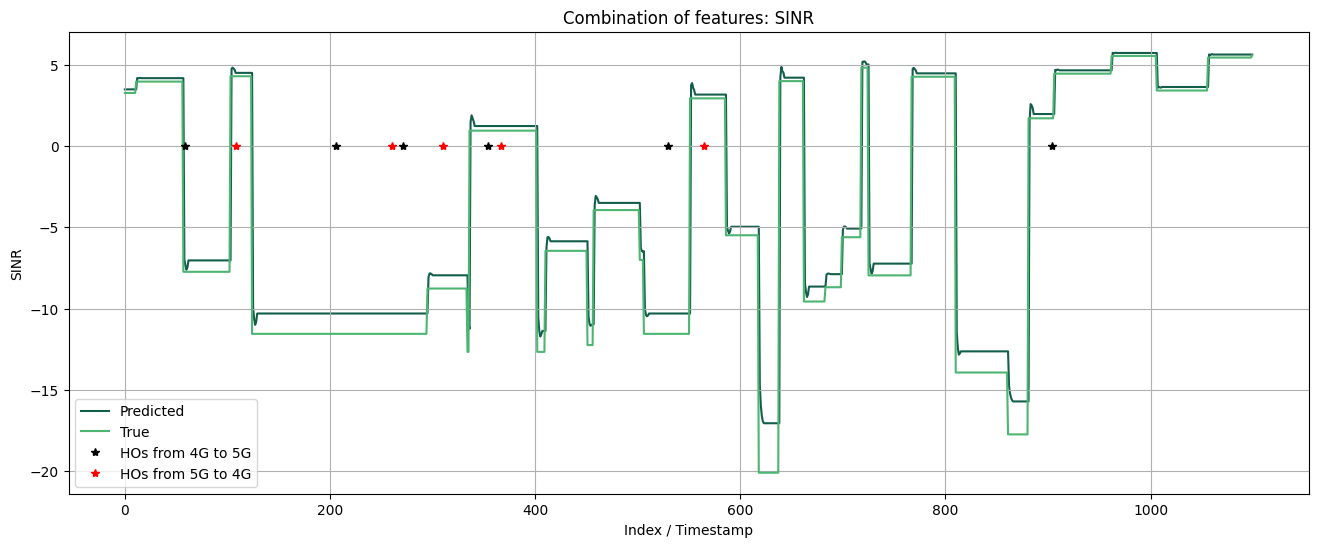

In [31]:
selected_combination = 'SINR'
combination = results[selected_combination]
y_pred = combination['y_pred']
y_true = combination['y_true']
mode = combination['mode_test']

hos_5g = check_handover(mode, '5g')
hos_4g = check_handover(mode, '4g')

when_5g_ho = []
when_4g_ho = []

for i in range(len(hos_5g)):
    if hos_5g[i] == 1:
        when_5g_ho.append(i)
    if hos_4g[i] == 1:
        when_4g_ho.append(i)

f = plt.figure(figsize=(16, 6))
plt.grid(zorder=0)
plt.plot(y_pred, label='Predicted', color=sinr_colors[0], zorder=1)
plt.plot(y_true, label='True', color=sinr_colors[1], zorder=2)
plt.plot(when_5g_ho, [0 for _ in range(len(when_5g_ho))], '*', color='black', label='HOs from 4G to 5G')
plt.plot(when_4g_ho, [0 for _ in range(len(when_4g_ho))], '*', color='red', label='HOs from 5G to 4G')
plt.xlabel('Index / Timestamp')
plt.ylabel('SINR')
plt.title(f'Combination of features: {selected_combination}')
plt.legend()
plt.show()

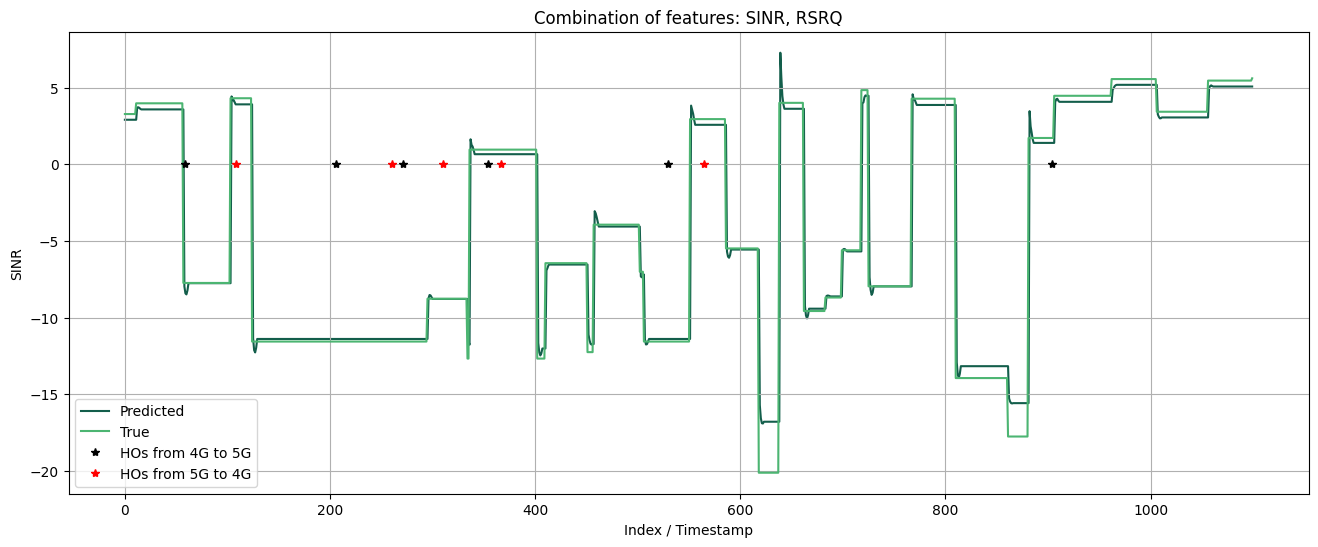

In [32]:
selected_combination = 'SINR, RSRQ'
combination = results[selected_combination]
y_pred = combination['y_pred']
y_true = combination['y_true']
mode = combination['mode_test']

hos_5g = check_handover(mode, '5g')
hos_4g = check_handover(mode, '4g')

when_5g_ho = []
when_4g_ho = []

for i in range(len(hos_5g)):
    if hos_5g[i] == 1:
        when_5g_ho.append(i)
    if hos_4g[i] == 1:
        when_4g_ho.append(i)

f = plt.figure(figsize=(16, 6))
plt.grid(zorder=0)
plt.plot(y_pred, label='Predicted', color=sinr_colors[0], zorder=1)
plt.plot(y_true, label='True', color=sinr_colors[1], zorder=2)
plt.plot(when_5g_ho, [0 for _ in range(len(when_5g_ho))], '*', color='black', label='HOs from 4G to 5G')
plt.plot(when_4g_ho, [0 for _ in range(len(when_4g_ho))], '*', color='red', label='HOs from 5G to 4G')
plt.xlabel('Index / Timestamp')
plt.ylabel('SINR')
plt.title(f'Combination of features: {selected_combination}')
plt.legend()
plt.show()

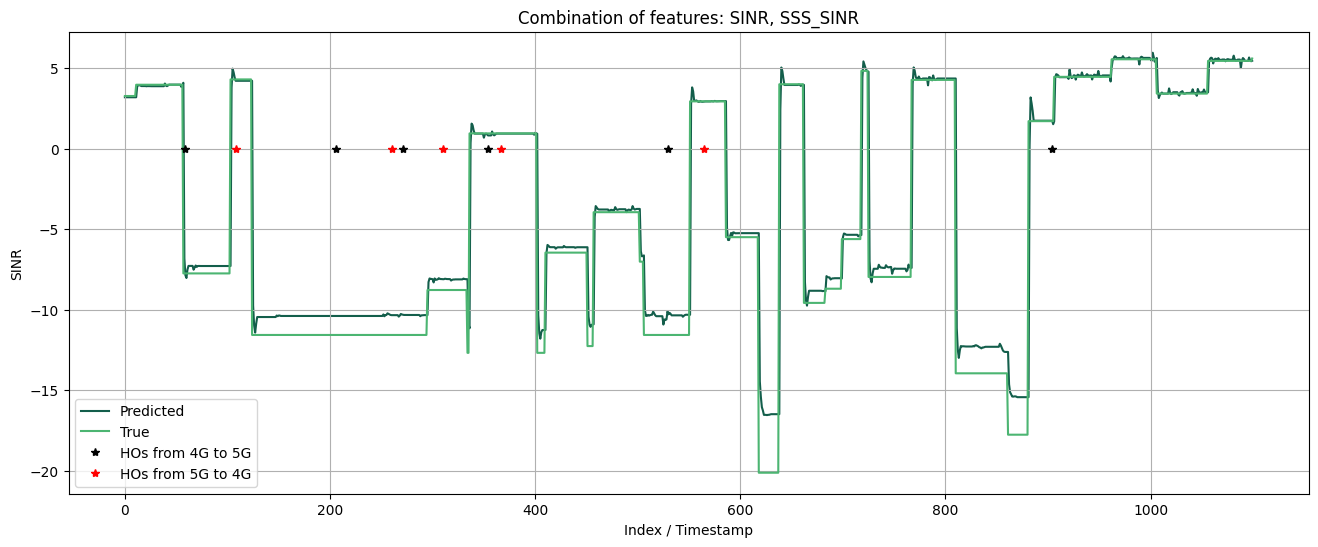

In [33]:
selected_combination = 'SINR, SSS_SINR'
combination = results[selected_combination]
y_pred = combination['y_pred']
y_true = combination['y_true']
mode = combination['mode_test']

hos_5g = check_handover(mode, '5g')
hos_4g = check_handover(mode, '4g')

when_5g_ho = []
when_4g_ho = []

for i in range(len(hos_5g)):
    if hos_5g[i] == 1:
        when_5g_ho.append(i)
    if hos_4g[i] == 1:
        when_4g_ho.append(i)

f = plt.figure(figsize=(16, 6))
plt.grid(zorder=0)
plt.plot(y_pred, label='Predicted', color=sinr_colors[0], zorder=1)
plt.plot(y_true, label='True', color=sinr_colors[1], zorder=2)
plt.plot(when_5g_ho, [0 for _ in range(len(when_5g_ho))], '*', color='black', label='HOs from 4G to 5G')
plt.plot(when_4g_ho, [0 for _ in range(len(when_4g_ho))], '*', color='red', label='HOs from 5G to 4G')
plt.xlabel('Index / Timestamp')
plt.ylabel('SINR')
plt.title(f'Combination of features: {selected_combination}')
plt.legend()
plt.show()

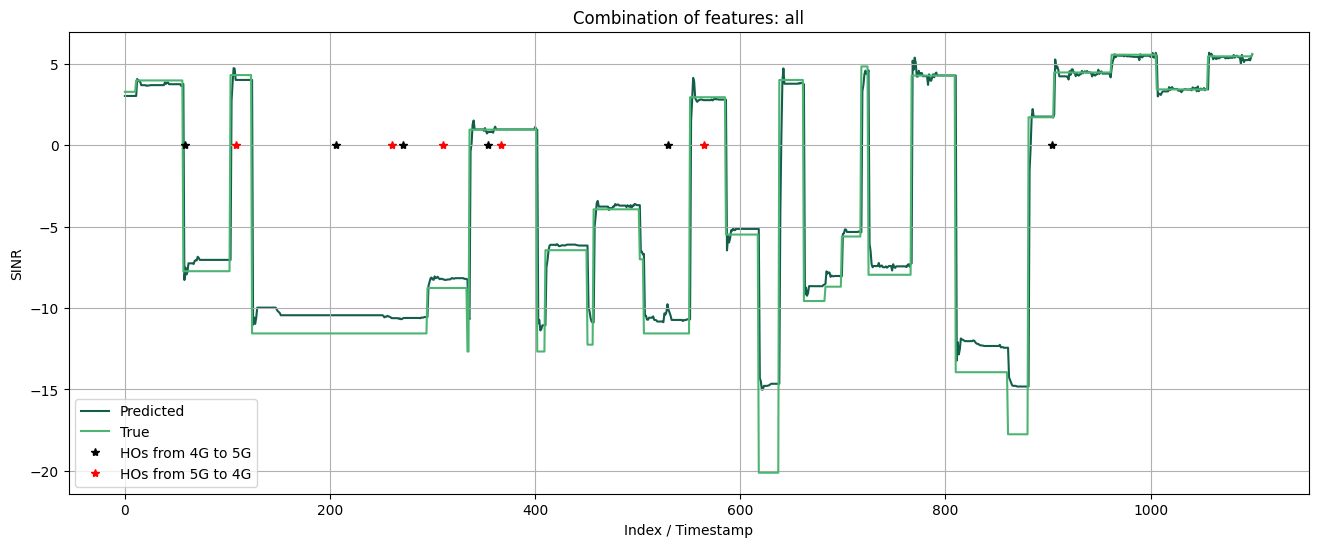

In [34]:
selected_combination = 'SINR, RSRP, RSRQ, SSS_RSRP, SSS_SINR, SSS_RSRQ'
combination = results[selected_combination]
y_pred = combination['y_pred']
y_true = combination['y_true']
mode = combination['mode_test']

hos_5g = check_handover(mode, '5g')
hos_4g = check_handover(mode, '4g')

when_5g_ho = []
when_4g_ho = []

for i in range(len(hos_5g)):
    if hos_5g[i] == 1:
        when_5g_ho.append(i)
    if hos_4g[i] == 1:
        when_4g_ho.append(i)

f = plt.figure(figsize=(16, 6))
plt.grid(zorder=0)
plt.plot(y_pred, label='Predicted', color=sinr_colors[0], zorder=1)
plt.plot(y_true, label='True', color=sinr_colors[1], zorder=2)
plt.plot(when_5g_ho, [0 for _ in range(len(when_5g_ho))], '*', color='black', label='HOs from 4G to 5G')
plt.plot(when_4g_ho, [0 for _ in range(len(when_4g_ho))], '*', color='red', label='HOs from 5G to 4G')
plt.xlabel('Index / Timestamp')
plt.ylabel('SINR')
plt.title(f'Combination of features: all')
plt.legend()
plt.show()

### Classification with Random Forest (using only SINR + RSRP)

In [35]:
# Preparation
selected_combination = 'SINR, RSRP, RSRQ'
combination = results[selected_combination]
y_pred = pd.DataFrame(combination['y_pred'], columns=['SINR'])
y_true = pd.DataFrame(combination['y_true'], columns=['SINR'])
mode = pd.DataFrame(combination['mode_test'], columns=['Mode'])

In [36]:
df, y = read_dataset('datasets/Op1_merged.csv', features=['SINR'])
rf = RandomForestClassifier()
rf.fit(df, y)

RandomForestClassifier()

In [37]:
y_true_mode = rf.predict(y_true)
accuracy = accuracy_score(mode, y_true_mode)
precision = precision_score(mode, y_true_mode)
recall = recall_score(mode, y_true_mode)
print(f'Scores for the true values of the SINR\nAccuracy: {accuracy:.3f}\nPrecision: {precision:.3f}\nRecall: {recall:.3f}')

Scores for the true values of the SINR
Accuracy: 0.855
Precision: 0.907
Recall: 0.654


In [38]:
y_pred_mode = rf.predict(y_pred)
accuracy = accuracy_score(mode, y_pred_mode)
precision = precision_score(mode, y_pred_mode)
recall = recall_score(mode, y_pred_mode)
print(f'Scores for the true values of the SINR\nAccuracy: {accuracy:.3f}\nPrecision: {precision:.3f}\nRecall: {recall:.3f}')

Scores for the true values of the SINR
Accuracy: 0.565
Precision: 0.118
Recall: 0.036


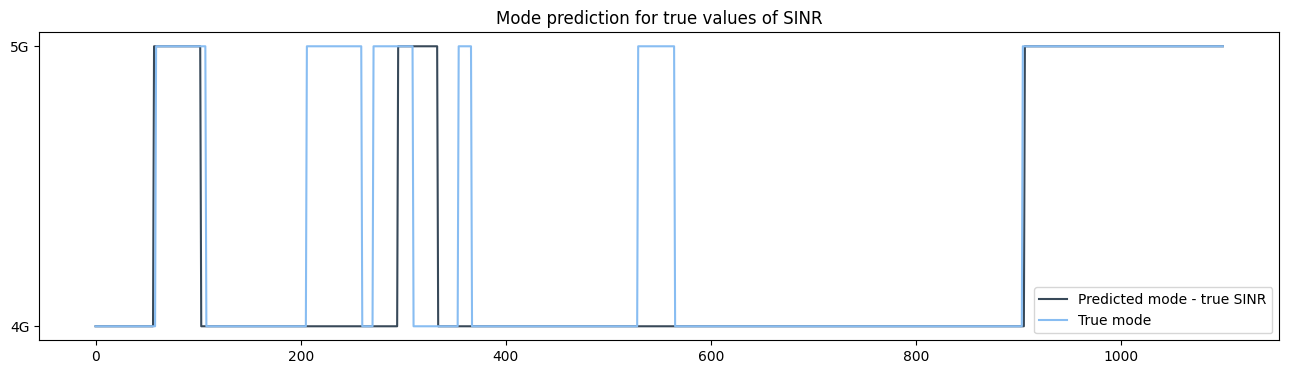

In [39]:
f = plt.figure(figsize=(16, 4))
plt.plot([i for i in range(len(y_true_mode))],y_true_mode, label='Predicted mode - true SINR', color=rsrp_colors[0])
plt.plot([i for i in range(len(mode))], mode, label='True mode', color=rsrp_colors[2])
plt.title('Mode prediction for true values of SINR')
plt.yticks([0, 1], ['4G', '5G'])
plt.legend()
plt.show()

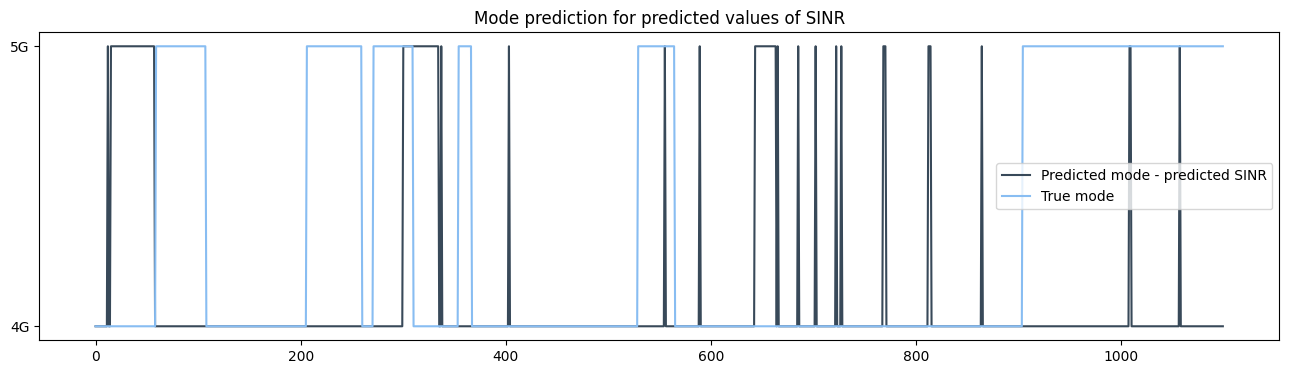

In [40]:
f = plt.figure(figsize=(16, 4))
plt.plot([i for i in range(len(y_pred_mode))],y_pred_mode, label='Predicted mode - predicted SINR', color=rsrp_colors[0])
plt.plot([i for i in range(len(mode))], mode, label='True mode', color=rsrp_colors[2])
plt.title('Mode prediction for predicted values of SINR')
plt.yticks([0, 1], ['4G', '5G'])
plt.legend()
plt.show()